In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import sys
sys.path.insert(1, '/Users/samuelwitte/Desktop/Magnetized_Plasma/Axion_Infall/src')
from AMC_Density_Evolution import *

from numba import jit
nside = 4
from mpl_toolkits import mplot3d
from matplotlib import ticker

from matplotlib import rc
rc('text', usetex=False)
wid=1.3
mpl.rcParams['axes.linewidth'] = wid #set the value globally
mpl.rcParams["font.family"] = "Times New Roman"


In [2]:
def dPower_Violin(fileList, n_side, filetag, Mass_a=1e-6, sve=False, sve_tag=""):
    fig, ax = plt.subplots(1,2, figsize=(12,7))
    fig.tight_layout(pad=5.0)

    data1 = []
    data2 = []
    pos_s = []
    for i in range(len(fileList)):
        
        file_in = np.load("../src/results/"+fileList[i])
    
        Theta = file_in[:,2]
        Phi = file_in[:,3]
        pixel_indices = hp.ang2pix(nside, Theta, Phi)

        indxs = hp.nside2npix(nside)
        rateT = np.sum(file_in[:,5])
        meanW = np.sum(file_in[:, 5] * file_in[:, 6]) / rateT
        rateSky = np.zeros(indxs)
        widthSky = np.zeros(indxs)
        
        for j in range(indxs):
            rel_rows = file_in[pixel_indices == j]
            if len(rel_rows) == 0:
                rateSky[j] = 1e-100
                widthSky[j] = 1e-10
                print("No photons...")
            else:
                if "Trajectories_MassAx" in fileList[i]:
                    rateSky[j] = np.log10(np.sum(rel_rows[:, 5] * Mass_a) / hp.pixelfunc.nside2resol(n_side))
                    widthSky[j] = np.log10(np.sqrt(np.sum(rel_rows[:, 5] * (rel_rows[:, 6] - meanW)**2) / np.sum(rel_rows[:, 5])))
                else:
                    rateSky[j] = np.log10(np.sum(rel_rows[:, 5] ) * 0.3e9  / hp.pixelfunc.nside2resol(n_side)) 
                    widthSky[j] = np.log10(np.sqrt(np.sum(rel_rows[:, 5] * (rel_rows[:, 6] - meanW)**2) / np.sum(rel_rows[:, 5])))

        pos_s.append(func_shift(i))
        data1.append(rateSky)
        data2.append(widthSky)

    parts1 = ax[0].violinplot(data1, widths=1, showmeans=False, showmedians=False, showextrema=False, positions=pos_s)
    parts2 = ax[1].violinplot(data2, widths=1, showmeans=False, showmedians=False, showextrema=False, positions=pos_s)
    clr = ['#80A1C1','#80A1C1','#58B09C']
    for i in range(len(fileList)):
        for pc in parts1['bodies']:

            pc.set_facecolor('#58B09C')
            
            
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
            pc.set_lw(1)
        for pc in parts2['bodies']:
            if "Trajectories_MassAx" in fileList[i]:
                pc.set_facecolor('#80A1C1')
            else:
                pc.set_facecolor('#80A1C1')

            pc.set_edgecolor('black')
            pc.set_alpha(0.7)

        quartile1, medians, quartile3 = np.percentile(data1[i], [25, 50, 75])
        whiskers = np.array([adjacent_values(data1[i], quartile1, quartile3) ])
        whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
        ax[0].scatter(func_shift(i) , medians, marker='x', color='#840032', s=100, zorder=3)
        cQtil= 'k'
        ax[0].vlines(func_shift(i), quartile1, quartile3, color=cQtil, linestyle='-', lw=1)
        epS = 0.05
        ax[0].hlines(quartile1, func_shift(i)- epS, func_shift(i)+ epS, color=cQtil, linestyle='-', lw=1)
        ax[0].hlines(quartile3, func_shift(i)- epS, func_shift(i) + epS, color=cQtil, linestyle='-', lw=1)

        quartile1, medians, quartile3 = np.percentile(data2[i], [25, 50, 75])
        whiskers = np.array([adjacent_values(data2[i], quartile1, quartile3) ])
        whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
        ax[1].scatter(func_shift(i) , medians, marker='x', color='#840032', s=100, zorder=3)
        cQtil= 'k'
        ax[1].vlines(func_shift(i), quartile1, quartile3, color=cQtil, linestyle='-', lw=1)
        epS = 0.05
        ax[1].hlines(quartile1, func_shift(i) - epS, func_shift(i) + epS, color=cQtil, linestyle='-', lw=1)
        ax[1].hlines(quartile3,func_shift(i) - epS, func_shift(i) + epS, color=cQtil, linestyle='-', lw=1)
    
    ax[0].set_ylabel(r"$\log_{{10}} \left<dP/d\Omega\right>$   [eV / s]", fontsize=22)
    ax[0].tick_params(direction='in', length=10, width=1, labelsize=16)#, colors='r',grid_color='r', grid_alpha=0.5)
    ax[0].tick_params(which='minor', direction='in', length=6, width=1, labelsize=12)
    
    ax[1].set_ylabel(r"$\log_{{10}} \Delta B$ ", fontsize=22)
    ax[1].tick_params(direction='in', length=10, width=1, labelsize=16)#, colors='r',grid_color='r', grid_alpha=0.5)
    ax[1].tick_params(which='minor', direction='in', length=6, width=1, labelsize=12)
    set_axis_style(ax[0], filetag, name="")
    set_axis_style(ax[1], filetag, name="")
    if sve:
        plt.savefig("../plots/Lumi_Violin_Example_"+sve_tag+".png", dpi=200)
        
    return

def dPower_Violin_pixelC(fileList, file2, n_side, filetag, Mass_a=1e-6, sve=False):
    fig, ax = plt.subplots(1, figsize=(12,7))
    fig.tight_layout(pad=5.0)

    file_in = np.load("../src/results/"+file2)
    Theta = file_in[:,2]
    Phi = file_in[:,3]
    pixel_indices = hp.ang2pix(nside, Theta, Phi)

    indxs = hp.nside2npix(nside)
    rateT = np.sum(file_in[:,5])
    BkgHalo = np.zeros(indxs)

    for j in range(indxs):
        rel_rows = file_in[pixel_indices == j]
        if len(rel_rows) == 0:
            BkgHalo[j] = 1e-100
            print("No photons...")
        else:
            BkgHalo[j] = np.sum(rel_rows[:, 5] * Mass_a) / hp.pixelfunc.nside2resol(n_side)
    
    
    data1 = []
    pos_s = []
    for i in range(len(fileList)):
        
        file_in = np.load("../src/results/"+fileList[i])
    
        Theta = file_in[:,2]
        Phi = file_in[:,3]
        pixel_indices = hp.ang2pix(nside, Theta, Phi)

        indxs = hp.nside2npix(nside)
        rateT = np.sum(file_in[:,5])
        rateSky = np.zeros(indxs)
        
        for j in range(indxs):
            rel_rows = file_in[pixel_indices == j]
            if len(rel_rows) == 0:
                rateSky[j] = 1e-100
                print("No photons...")
            else:
                rateSky[j] = np.log10(np.sum(rel_rows[:, 5] ) * 0.3e9  / hp.pixelfunc.nside2resol(n_side) / BkgHalo[j]) 

        pos_s.append(func_shift(i))
        data1.append(rateSky)
        
    parts1 = ax.violinplot(data1, widths=1, showmeans=False, showmedians=False, showextrema=False, positions=pos_s)
    clr = ['#80A1C1','#80A1C1','#58B09C']
    for i in range(len(fileList)):
        for pc in parts1['bodies']:

            pc.set_facecolor('#58B09C')
            
            
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
            pc.set_lw(1)

        quartile1, medians, quartile3 = np.percentile(data1[i], [25, 50, 75])
        whiskers = np.array([adjacent_values(data1[i], quartile1, quartile3) ])
        whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
        ax.scatter(func_shift(i) , medians, marker='x', color='#840032', s=100, zorder=3)
        cQtil= 'k'
        ax.vlines(func_shift(i), quartile1, quartile3, color=cQtil, linestyle='-', lw=1)
        epS = 0.05
        ax.hlines(quartile1, func_shift(i)- epS, func_shift(i)+ epS, color=cQtil, linestyle='-', lw=1)
        ax.hlines(quartile3, func_shift(i)- epS, func_shift(i) + epS, color=cQtil, linestyle='-', lw=1)

    
    
    ax.set_ylabel(r"$\log_{{10}} ( \left<dP\right>  / \left<dP\right>_{halo} )$", fontsize=22)
    ax.tick_params(direction='in', length=10, width=1, labelsize=16)#, colors='r',grid_color='r', grid_alpha=0.5)
    ax.tick_params(which='minor', direction='in', length=6, width=1, labelsize=12)
    
    set_axis_style(ax, filetag, name="")
    if sve:
        plt.savefig("../plots/Lumi_Violin_Example_Pixel_by_Pixel.png", dpi=200)
        
    return
    
def func_shift(i):
    return 2*i + 1

def func_shift2(i):
    return 4*i + 1
    
def set_axis_style(ax, labels, name=""):
    ax.get_xaxis().set_tick_params(direction='in')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, func_shift(len(labels)-1)+1 , 2))

    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, func_shift(len(labels)-1) + 0.75)
    ax.set_xlabel(name, fontsize=22)
    
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def set_axis_style2(ax, labels, name=""):
    ax.get_xaxis().set_tick_params(direction='in')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, func_shift2(len(labels)-1)+1 , 4))
    ax.set_xticklabels(labels)
    ax.set_xlim(-3.0, func_shift2(len(labels)-1) + 4)
    ax.set_xlabel(name, fontsize=22)
    

def dPower_Violin_TimeEvol(fileN, Mamc, b, v_NS, rho_amc, n_side, Mass_a=1e-6, file2=None, sve=False):
    fig, ax = plt.subplots(1, figsize=(10,7))
    fig.tight_layout(pad=5.0)

    data1 = []
    filetag = []
    pos_s = []
    
    tmax = AMC_CrossingTime(b, Mamc, v_NS, rho_amc)
    epsshift = tmax * 1e-10
    tlist = np.linspace(epsshift, tmax-epsshift, 10)[1:]
        
    file_in = np.load("../src/results/"+fileN)
    
    Theta = file_in[:,2]
    Phi = file_in[:,3]
    pixel_indices = hp.ang2pix(nside, Theta, Phi)

    indxs = hp.nside2npix(nside)
    rateT = np.sum(file_in[:,5])
    meanW = np.sum(file_in[:, 5] * file_in[:, 6]) / rateT
    rateSky = np.zeros(indxs)
    rateSky_STD = np.zeros(indxs)


    for j in range(indxs):
        rel_rows = file_in[pixel_indices == j]
        if len(rel_rows) == 0:
            rateSky[j] = 1e-100
            print("No photons...")
        else:
            rateSky[j] = np.sum(rel_rows[:, 5]  / hp.pixelfunc.nside2resol(n_side)) 
            
    if file2 is not None:
        file_in = np.load("../src/results/"+file2)
        Theta = file_in[:,2]
        Phi = file_in[:,3]
        pixel_indices = hp.ang2pix(nside, Theta, Phi)

        indxs = hp.nside2npix(nside)
        rateT = np.sum(file_in[:,5])
        rateSky_STD = np.zeros(indxs)

        for j in range(indxs):
            rel_rows = file_in[pixel_indices == j]
            if len(rel_rows) == 0:
                rateSky_STD[j] = 1e-100
                print("No photons...")
            else:
                rateSky_STD[j] = np.sum(rel_rows[:, 5] * Mass_a  / hp.pixelfunc.nside2resol(n_side))
        
        # top = np.percentile(rateSky, 90)
        # bottom = np.percentile(rateSky, 10)
        # ax.fill_between([-10, 100], top, y2=bottom, color='k', alpha=0.2)
        
    for i in range(len(tlist)):
        # dense in GeV / cm^3
        dense = AMC_DensityEval(b, Mamc, v_NS, tlist[i], rho_amc)
        pos_s.append(func_shift2(i))
        rate = rateSky * dense / rateSky_STD

        data1.append(np.log10(rate))
        
        filetag.append('{:.2f}'.format(tlist[i] / 60 / 60 / 24))

            
            
    
        
    parts1 = ax.violinplot(data1, widths=3, showmeans=False, showmedians=False, showextrema=False, positions=pos_s)
    
    clr = ['#80A1C1','#80A1C1','#58B09C']
    for i in range(len(tlist)):
        for pc in parts1['bodies']:

            pc.set_facecolor(clr[2])
            
            
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
            pc.set_lw(1)


        quartile1, medians, quartile3 = np.percentile(data1[i], [25, 50, 75])
        whiskers = np.array([adjacent_values(data1[i], quartile1, quartile3) ])
        whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
        ax.scatter(func_shift2(i) , medians, marker='x', color='#840032', s=100, zorder=3)
        cQtil= 'k'
        ax.vlines(func_shift2(i), quartile1, quartile3, color=cQtil, linestyle='-', lw=1)
        epS = 0.05
        ax.hlines(quartile1, func_shift2(i)- epS, func_shift2(i) + epS, color=cQtil, linestyle='-', lw=1)
        ax.hlines(quartile3, func_shift2(i)- epS, func_shift2(i) + epS, color=cQtil, linestyle='-', lw=1)

       
    
    ax.set_ylabel(r"$\log_{{10}} \left( \left<dP\right>_{amc} / \left<dP\right>_{halo} \right)$", fontsize=18)

    ax.tick_params(direction='in', length=10, width=1, labelsize=16)#, colors='r',grid_color='r', grid_alpha=0.5)
    ax.tick_params(which='minor', direction='in', length=6, width=1, labelsize=12)
    set_axis_style2(ax, filetag, name=r"Time  [days]")
    ax.set_ylim([-6, 3])
    
    #if file2 is not None:
    #    ax.text(11, 28, "Smooth Halo", fontsize=26)
    plt.axhline(y=0.0, color='k', linestyle='--')

    if sve:
        plt.savefig("../plots/TimeEvol_Lumi_Violin_Example_.png", dpi=200)
        
    return
    
def delTime_test(Mamc, b, v_NS, rho_amc):
    # check optimal time binning
    fig, ax = plt.subplots(1, figsize=(7,5))
    epsshift = 1e-10
    tmax = AMC_CrossingTime(b, Mamc, v_NS, rho_amc) # seconds
    t_center = tmax/2 #seconds
    
    tlist_cuts = [tmax-1.0, tmax/5, tmax/1e2, tmax/1e4, tmax/1e5]
    sln = np.zeros(len(tlist_cuts))
    for i in range(len(tlist_cuts)):
        
        tlist = np.linspace(t_center - tlist_cuts[i], t_center + tlist_cuts[i], 200)
        dense = np.zeros_like(tlist)
        for j in range(len(tlist)):
        # dense in GeV / cm^3
            dense[j] = AMC_DensityEval(b, Mamc, v_NS, tlist[j], rho_amc)
        sln[i] = np.trapz(dense, tlist)/ (2*tlist_cuts[i])
    print(np.column_stack((tlist_cuts, sln)))
    
#    plt.yscale('log')
    
    return


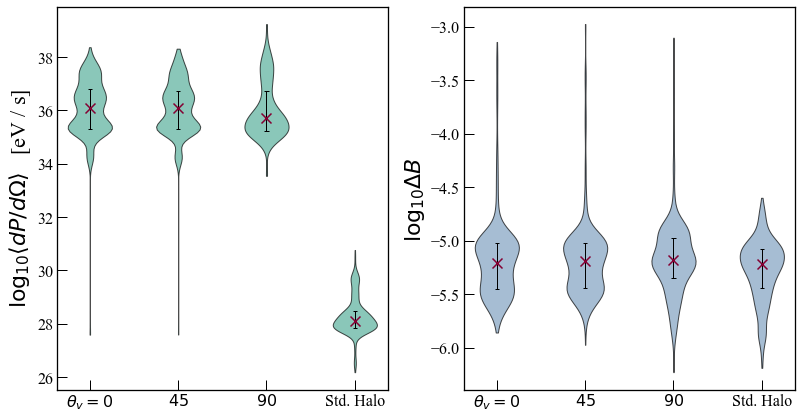

In [3]:
fileN = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1_NS_Mag_0.00067_NS_Theta_0.0__.npz"
fileN1 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1_NS_Mag_0.00267_NS_Theta_1.571__.npz"
fileN2 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1_NS_Mag_0.00067_NS_Theta_3.142__.npz"
fileNLAST ="Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
fileL = [fileN, fileN2,fileN1, fileNLAST]
filetag = [r'$\theta_v = 0$',  r'$45$', r'$90$', 'Std. Halo']
sve_tag= "_angles_"
nside = 8
Mass_a=1e-6
sve=True
dPower_Violin(fileL, nside, filetag,Mass_a=Mass_a, sve=sve, sve_tag=sve_tag)

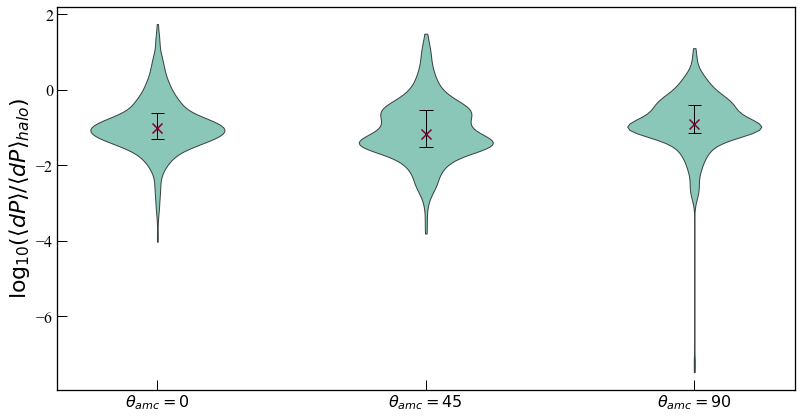

In [21]:
fileN = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0007__.npz"
fileN1 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velZ_0.0007__.npz"
fileN2 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0005NS_velZ_0.0005__.npz"
fileL = [fileN, fileN2,fileN1]
filetag = [r'$\theta_{amc} = 0$',  r'$\theta_{amc} = 45$', r'$\theta_{amc} = 90$']
fileNstd ="Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
n_side = 8
Mass_a=1e-6
sve=True
dPower_Violin_pixelC(fileL, fileNstd, n_side, filetag, Mass_a=Mass_a, sve=sve)

In [ ]:
fileN1 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0001NS_velZ_0.0001__.npz"
fileN2 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0005NS_velZ_0.0005__.npz"
fileN3 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0019NS_velZ_0.0019__.npz"
fileNLAST ="Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
fileL = [fileN1, fileN2, fileN3]
filetag = [r'$|v|$ = 50 km/s', r'200 km/s', r'800 km/s']
fileNstd ="Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
n_side = 8
Mass_a=1e-6
sve=False
dPower_Violin_pixelC(fileL, fileNstd, n_side, filetag, Mass_a=Mass_a, sve=sve)

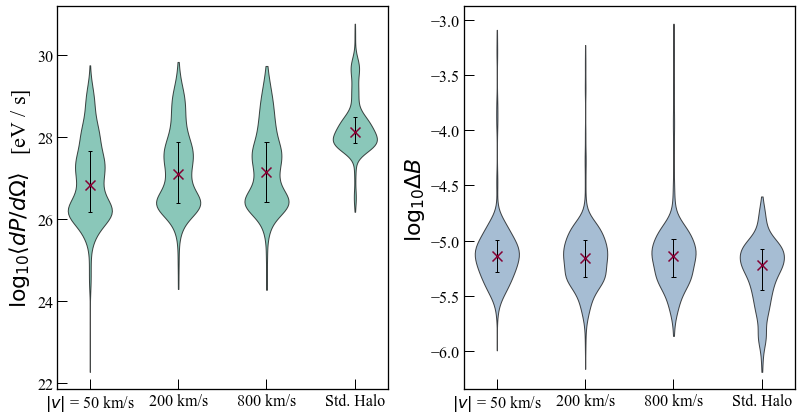

In [20]:
fileN1 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0001NS_velZ_0.0001__.npz"
fileN2 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0005NS_velZ_0.0005__.npz"
fileN3 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0019NS_velZ_0.0019__.npz"
fileNLAST ="Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
fileL = [fileN1, fileN2, fileN3, fileNLAST]
filetag = [r'$|v|$ = 50 km/s', r'200 km/s', r'800 km/s', 'Std. Halo']
sve_tag= "_vmag_"
nside = 8
Mass_a=1e-6
sve=True
dPower_Violin(fileL, nside, filetag,Mass_a=Mass_a, sve=sve, sve_tag=sve_tag)

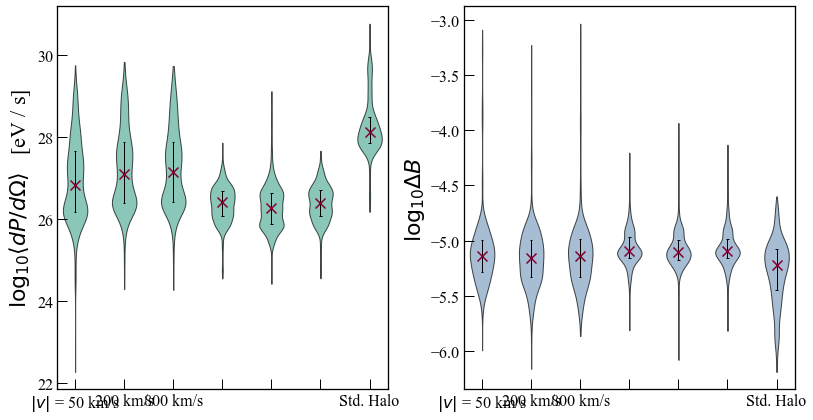

In [31]:
fileN1 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0001NS_velZ_0.0001__.npz"
fileN2 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0005NS_velZ_0.0005__.npz"
fileN3 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0019NS_velZ_0.0019__.npz"
fileN4 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0005NS_velZ_0.0005__NoCLCut__.npz"
fileN5 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velZ_0.0007__NoCLCut__.npz"
fileN6 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0019NS_velZ_0.0019__NoCLCut__.npz"
fileNLAST ="Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
fileL = [fileN1, fileN2, fileN3, fileN4, fileN5, fileN6, fileNLAST]
filetag = [r'$|v|$ = 50 km/s', r'200 km/s', r'800 km/s', '', '', '', 'Std. Halo']
sve_tag= "_vmag_"
nside = 8
Mass_a=1e-6
sve=False
dPower_Violin(fileL, nside, filetag,Mass_a=Mass_a, sve=sve, sve_tag=sve_tag)

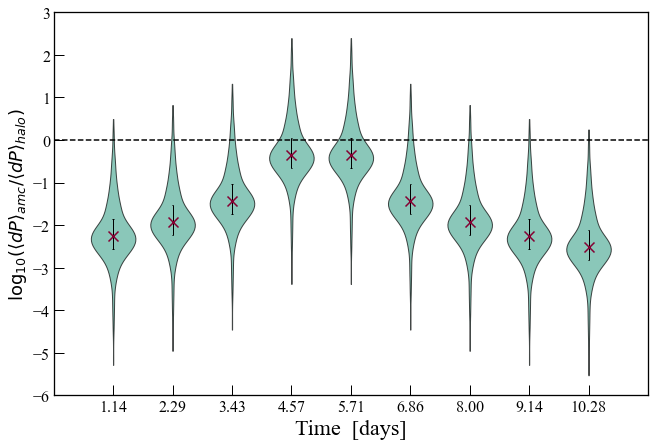

In [28]:
fileN2 = "Minicluster_PeriodAvg_MassAx_1.0e-6_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10_MassNS_1NS_velX_0.0005NS_velZ_0.0005__.npz"
file2 = "Trajectories_MassAx_1.0e-6_AxionG_1.0e-12_ThetaM_0.2_rotPulsar_1.0_B0_1.0e14_rNS_10.0_MassNS_1.0_DispersionEq_wNR_Ax_trajs_1000000_MaxR_1.0_cutT_100_batchS_10_N_Times_1000__fixed_time_0.0_odeErr_1.0e-8_.npz"
nside = 8
Mass_a=1e-6
sve=True
Mamc = 1e-10
b = 10**-8 * 3.086*10**13 # km 
v_NS = np.array([0, 0, 200 / 2.998e5])
rho_amc = 1e6 # M /pc^3
n_side=8
dPower_Violin_TimeEvol(fileN, Mamc, b, v_NS, rho_amc, n_side, Mass_a=Mass_a, file2= file2, sve=sve)

[[5.55517591e+05 2.14973096e+07]
 [1.11103718e+05 7.58631930e+07]
 [5.55518591e+03 1.02382419e+08]
 [5.55518591e+01 1.02494299e+08]
 [5.55518591e+00 1.02494310e+08]]


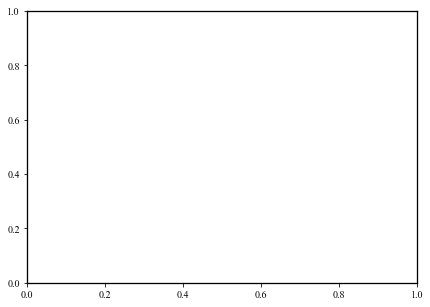

In [14]:
Mamc = 1e-10
b = 10**-6 * 3.086*10**13 # km 
v_NS = np.array([0, 0, 300 / 2.998e5])
rho_amc = 1e6 # M /pc^3
delTime_test(Mamc, b, v_NS, rho_amc)